In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [31]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 0.25

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+design_region_height+monitor_position+monitor_blank+tpml, 1)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [32]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [33]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [34]:
num_sources = 3
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag]
    )
    for src in sources
]

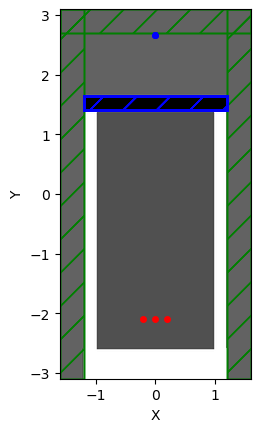

In [35]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(0, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]

def J(fields):
    return npa.sum(npa.real(fields) ** 2)

opt_list = [
    mpa.OptimizationProblem(
        simulation=sims[i],
        objective_functions=[J],
        objective_arguments=[FourierFields_list[i]],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )
    for i in range(num_sources)
]
for i in range(num_sources):
    opt_list[i].plot2D(True)

In [23]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [24]:
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)



--- Iter 1 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0030632396006422015, 0.1018241724452966, 0.0030632396006421]
Mean FoM: 0.035984
Binarization degree: 0.0894


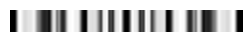


--- Iter 2 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0032367893721232882, 0.10437619016723595, 0.003236789372123197]
Mean FoM: 0.036950
Binarization degree: 0.0896


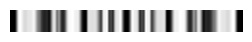


--- Iter 3 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0035870878339995097, 0.10951657779749202, 0.003587087833999395]
Mean FoM: 0.038897
Binarization degree: 0.0906


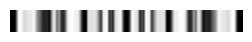


--- Iter 4 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.004115499299935089, 0.11732478006189803, 0.004115499299934994]
Mean FoM: 0.041852
Binarization degree: 0.0934


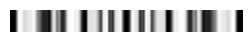


--- Iter 5 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.004850249156621592, 0.12806200280795269, 0.004850249156621464]
Mean FoM: 0.045921
Binarization degree: 0.0997


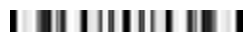


--- Iter 6 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0058630338124952336, 0.14220686315431771, 0.005863033812495093]
Mean FoM: 0.051311
Binarization degree: 0.1073


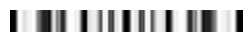


--- Iter 7 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.007169492892592127, 0.16004492272972845, 0.007169492892592053]
Mean FoM: 0.058128
Binarization degree: 0.1173


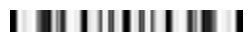


--- Iter 8 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0087403061402574, 0.18140075999221114, 0.00874030614025722]
Mean FoM: 0.066294
Binarization degree: 0.1322


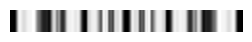


--- Iter 9 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.010898971449053295, 0.20786320154071494, 0.01089897144905314]
Mean FoM: 0.076554
Binarization degree: 0.1549


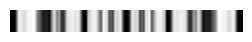


--- Iter 10 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.013587107849756468, 0.23770480142205305, 0.01358710784975631]
Mean FoM: 0.088293
Binarization degree: 0.1825


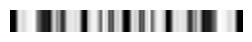


--- Iter 11 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.016190700146193164, 0.26725865827248263, 0.016190700146192998]
Mean FoM: 0.099880
Binarization degree: 0.2106


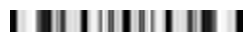


--- Iter 12 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.017828706300393737, 0.29102585057379926, 0.017828706300393574]
Mean FoM: 0.108894
Binarization degree: 0.2394


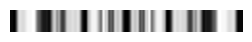


--- Iter 13 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.019827091080987232, 0.31030641942961007, 0.019827091080987028]
Mean FoM: 0.116654
Binarization degree: 0.2674


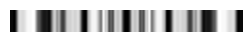


--- Iter 14 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.022070891023157155, 0.32433621473323637, 0.022070891023156933]
Mean FoM: 0.122826
Binarization degree: 0.2937


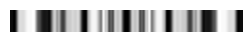


--- Iter 15 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.023167766848091527, 0.3357112200216194, 0.023167766848091242]
Mean FoM: 0.127349
Binarization degree: 0.3161


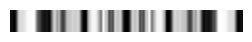


--- Iter 16 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.02490076796905957, 0.3449791057840839, 0.02490076796905936]
Mean FoM: 0.131594
Binarization degree: 0.3359


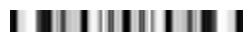


--- Iter 17 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.027725511127499096, 0.35244918341884673, 0.027725511127498857]
Mean FoM: 0.135967
Binarization degree: 0.3538


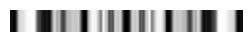


--- Iter 18 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.029685174824480746, 0.359734167633964, 0.029685174824480375]
Mean FoM: 0.139702
Binarization degree: 0.3716


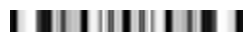


--- Iter 19 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03167675548414271, 0.36555441265832883, 0.03167675548414227]
Mean FoM: 0.142969
Binarization degree: 0.3898


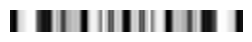


--- Iter 20 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.034804693307121715, 0.3687363234745721, 0.034804693307121375]
Mean FoM: 0.146115
Binarization degree: 0.4060


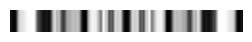


--- Iter 21 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03697753775828671, 0.3712265184180722, 0.03697753775828622]
Mean FoM: 0.148394
Binarization degree: 0.4201


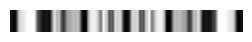


--- Iter 22 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.03874968360338688, 0.3726988648838551, 0.038749683603386334]
Mean FoM: 0.150066
Binarization degree: 0.4341


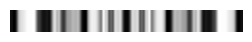


--- Iter 23 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.041437435467448006, 0.37256574116463836, 0.041437435467447575]
Mean FoM: 0.151814
Binarization degree: 0.4489


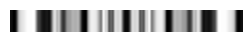


--- Iter 24 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04263516914411973, 0.3761739115450078, 0.04263516914411918]
Mean FoM: 0.153815
Binarization degree: 0.4638


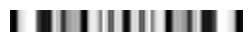


--- Iter 25 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04496830228018037, 0.37980840993632636, 0.044968302280180034]
Mean FoM: 0.156582
Binarization degree: 0.4765


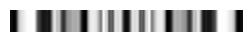


--- Iter 26 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.047052782250597565, 0.3856944818667743, 0.047052782250597135]
Mean FoM: 0.159933
Binarization degree: 0.4871


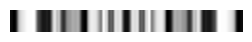


--- Iter 27 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.04857530330948443, 0.3938561873352829, 0.04857530330948392]
Mean FoM: 0.163669
Binarization degree: 0.4956


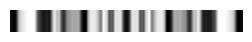


--- Iter 28 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05088993599261889, 0.39968023584771356, 0.05088993599261842]
Mean FoM: 0.167153
Binarization degree: 0.5023


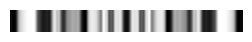


--- Iter 29 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05246661966229433, 0.4058485333263859, 0.052466619662293885]
Mean FoM: 0.170261
Binarization degree: 0.5073


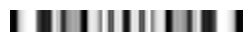


--- Iter 30 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05360108385794307, 0.41116323403673505, 0.05360108385794257]
Mean FoM: 0.172788
Binarization degree: 0.5120


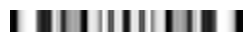


--- Iter 31 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05515126166443944, 0.41365802470776153, 0.05515126166443886]
Mean FoM: 0.174654
Binarization degree: 0.5179


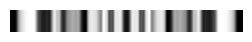


--- Iter 32 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.056065540726816736, 0.4164127105906801, 0.05606554072681625]
Mean FoM: 0.176181
Binarization degree: 0.5227


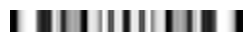


--- Iter 33 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05668389455106171, 0.418732085788662, 0.056683894551061154]
Mean FoM: 0.177367
Binarization degree: 0.5269


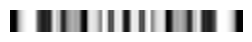


--- Iter 34 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.057572070534320445, 0.41937574984809456, 0.05757207053432]
Mean FoM: 0.178173
Binarization degree: 0.5308


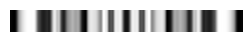


--- Iter 35 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05806442666006335, 0.42050557185096343, 0.05806442666006292]
Mean FoM: 0.178878
Binarization degree: 0.5340


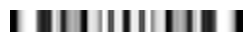


--- Iter 36 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.058226919429501076, 0.42254791765104316, 0.0582269194295007]
Mean FoM: 0.179667
Binarization degree: 0.5363


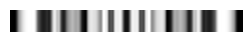


--- Iter 37 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.058739804281252805, 0.42361978849140525, 0.05873980428125249]
Mean FoM: 0.180366
Binarization degree: 0.5400


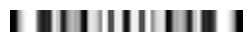


--- Iter 38 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.059091852537902924, 0.42606367636293624, 0.059091852537902737]
Mean FoM: 0.181416
Binarization degree: 0.5438


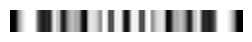


--- Iter 39 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.059260226403515595, 0.4302538805821779, 0.0592602264035153]
Mean FoM: 0.182925
Binarization degree: 0.5476


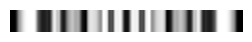


--- Iter 40 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.05981562628447913, 0.4335801856415246, 0.05981562628447871]
Mean FoM: 0.184404
Binarization degree: 0.5517


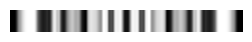


--- Iter 41 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.060162012604145255, 0.43758655919171424, 0.060162012604144645]
Mean FoM: 0.185970
Binarization degree: 0.5555


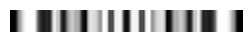


--- Iter 42 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06025062736933417, 0.44178131820235617, 0.060250627369333835]
Mean FoM: 0.187428
Binarization degree: 0.5596


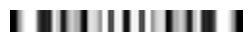


--- Iter 43 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.060604141910566144, 0.4441337698950106, 0.06060414191056564]
Mean FoM: 0.188447
Binarization degree: 0.5647


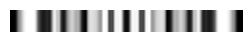


--- Iter 44 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06065995862868681, 0.4465078248437826, 0.060659958628686304]
Mean FoM: 0.189276
Binarization degree: 0.5705


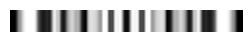


--- Iter 45 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06059391742476994, 0.44843833137609623, 0.06059391742476973]
Mean FoM: 0.189875
Binarization degree: 0.5766


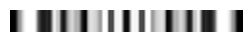


--- Iter 46 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.060814883527608866, 0.44890638621599693, 0.060814883527608436]
Mean FoM: 0.190179
Binarization degree: 0.5824


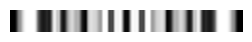


--- Iter 47 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06077596268444712, 0.4498760790773179, 0.060775962684446586]
Mean FoM: 0.190476
Binarization degree: 0.5879


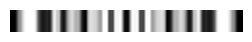


--- Iter 48 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06080429056559569, 0.4503822558324267, 0.0608042905655953]
Mean FoM: 0.190664
Binarization degree: 0.5931


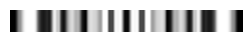


--- Iter 49 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0610162693708831, 0.4501500670120346, 0.06101626937088296]
Mean FoM: 0.190728
Binarization degree: 0.5979


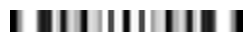


--- Iter 50 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06099795407219577, 0.4508629995689277, 0.06099795407219567]
Mean FoM: 0.190953
Binarization degree: 0.6023


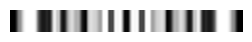


--- Iter 51 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.061193042406137196, 0.4510817780311266, 0.06119304240613691]
Mean FoM: 0.191156
Binarization degree: 0.6065


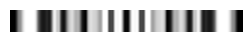


--- Iter 52 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06142422324562806, 0.4514591761457806, 0.06142422324562776]
Mean FoM: 0.191436
Binarization degree: 0.6104


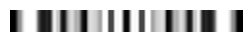


--- Iter 53 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.061530271209333666, 0.4526188147847662, 0.06153027120933333]
Mean FoM: 0.191893
Binarization degree: 0.6140


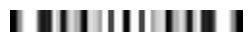


--- Iter 54 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06187745237370988, 0.45309439443198773, 0.06187745237370959]
Mean FoM: 0.192283
Binarization degree: 0.6176


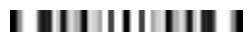


--- Iter 55 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06212898257601988, 0.45384202117382827, 0.062128982576019676]
Mean FoM: 0.192700
Binarization degree: 0.6208


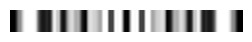


--- Iter 56 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.062298335840762095, 0.4547845364939538, 0.06229833584076175]
Mean FoM: 0.193127
Binarization degree: 0.6239


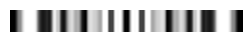


--- Iter 57 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06268268227294468, 0.45478826830087216, 0.06268268227294452]
Mean FoM: 0.193385
Binarization degree: 0.6269


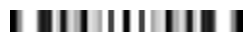


--- Iter 58 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06291261194211564, 0.455215472101501, 0.06291261194211553]
Mean FoM: 0.193680
Binarization degree: 0.6297


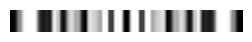


--- Iter 59 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06315714870829295, 0.45530972257081886, 0.06315714870829273]
Mean FoM: 0.193875
Binarization degree: 0.6322


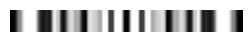


--- Iter 60 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0634816550327121, 0.4549763436127579, 0.06348165503271196]
Mean FoM: 0.193980
Binarization degree: 0.6347


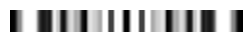


--- Iter 61 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06369563858036495, 0.4550565763581518, 0.06369563858036474]
Mean FoM: 0.194149
Binarization degree: 0.6370


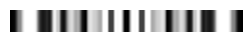


--- Iter 62 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06397178953771333, 0.45491299939198904, 0.06397178953771314]
Mean FoM: 0.194286
Binarization degree: 0.6393


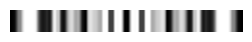


--- Iter 63 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06426682523188772, 0.45476812625543417, 0.06426682523188758]
Mean FoM: 0.194434
Binarization degree: 0.6414


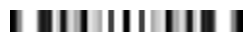


--- Iter 64 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06447650837373685, 0.4550571099605508, 0.06447650837373685]
Mean FoM: 0.194670
Binarization degree: 0.6434


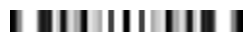


--- Iter 65 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06475554991198611, 0.4551512385449452, 0.06475554991198602]
Mean FoM: 0.194887
Binarization degree: 0.6453


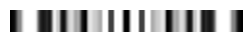


--- Iter 66 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06498680063747649, 0.4554331428536513, 0.06498680063747635]
Mean FoM: 0.195136
Binarization degree: 0.6478


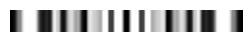


--- Iter 67 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06516241355844098, 0.45585469962651726, 0.06516241355844081]
Mean FoM: 0.195393
Binarization degree: 0.6505


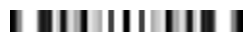


--- Iter 68 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06537160611048769, 0.4560237021651304, 0.06537160611048742]
Mean FoM: 0.195589
Binarization degree: 0.6531


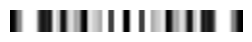


--- Iter 69 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06549629950224595, 0.4563387446519271, 0.06549629950224553]
Mean FoM: 0.195777
Binarization degree: 0.6557


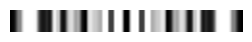


--- Iter 70 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06560872933197986, 0.4565328723797538, 0.06560872933197955]
Mean FoM: 0.195917
Binarization degree: 0.6582


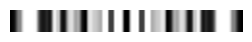


--- Iter 71 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06573137687000821, 0.45655875710382715, 0.06573137687000781]
Mean FoM: 0.196007
Binarization degree: 0.6608


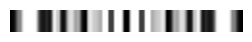


--- Iter 72 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06578585584911018, 0.4567042979896894, 0.06578585584910988]
Mean FoM: 0.196092
Binarization degree: 0.6633


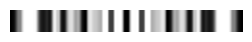


--- Iter 73 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0658524125647016, 0.45674284259646564, 0.06585241256470106]
Mean FoM: 0.196149
Binarization degree: 0.6659


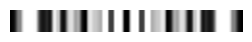


--- Iter 74 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06590104978490965, 0.45685067167304844, 0.06590104978490938]
Mean FoM: 0.196218
Binarization degree: 0.6684


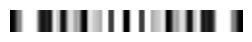


--- Iter 75 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0659190567244697, 0.4570838454329203, 0.06591905672446956]
Mean FoM: 0.196307
Binarization degree: 0.6706


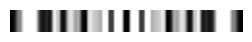


--- Iter 76 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06591831629294563, 0.45741861587288185, 0.06591831629294534]
Mean FoM: 0.196418
Binarization degree: 0.6728


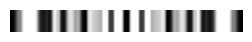


--- Iter 77 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06594592125807208, 0.45769047132413937, 0.06594592125807179]
Mean FoM: 0.196527
Binarization degree: 0.6750


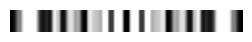


--- Iter 78 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06591300850024703, 0.45821107985728354, 0.0659130085002469]
Mean FoM: 0.196679
Binarization degree: 0.6770


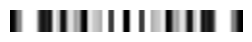


--- Iter 79 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06593930141160499, 0.4584840366254041, 0.06593930141160485]
Mean FoM: 0.196788
Binarization degree: 0.6790


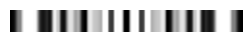


--- Iter 80 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06592968537491947, 0.45886716736638405, 0.06592968537491928]
Mean FoM: 0.196909
Binarization degree: 0.6808


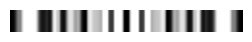


--- Iter 81 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06590272597178189, 0.45927898247213195, 0.0659027259717815]
Mean FoM: 0.197028
Binarization degree: 0.6826


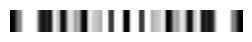


--- Iter 82 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0659421994765638, 0.45939137817349357, 0.06594219947656374]
Mean FoM: 0.197092
Binarization degree: 0.6844


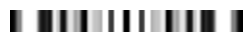


--- Iter 83 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06589897971967379, 0.4597802935834258, 0.06589897971967358]
Mean FoM: 0.197193
Binarization degree: 0.6861


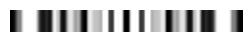


--- Iter 84 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0659238363551106, 0.4598712849882236, 0.06592383635511022]
Mean FoM: 0.197240
Binarization degree: 0.6879


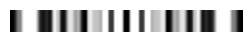


--- Iter 85 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06593118823332363, 0.4600095141930247, 0.06593118823332349]
Mean FoM: 0.197291
Binarization degree: 0.6896


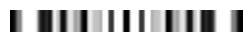


--- Iter 86 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06591479185237537, 0.46024625023366167, 0.06591479185237525]
Mean FoM: 0.197359
Binarization degree: 0.6912


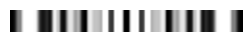


--- Iter 87 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.0659724695719129, 0.46021428797017516, 0.0659724695719127]
Mean FoM: 0.197386
Binarization degree: 0.6929


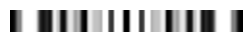


--- Iter 88 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06597199752349056, 0.4604626033172491, 0.06597199752349048]
Mean FoM: 0.197469
Binarization degree: 0.6943


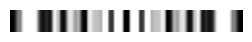


--- Iter 89 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06602833715868876, 0.4605314258277857, 0.06602833715868846]
Mean FoM: 0.197529
Binarization degree: 0.6958


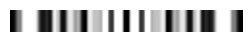


--- Iter 90 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06608384499828385, 0.4606394223244621, 0.06608384499828354]
Mean FoM: 0.197602
Binarization degree: 0.6972


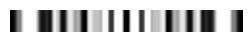


--- Iter 91 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.000
FoM values: [0.06612208802838926, 0.4608338665477083, 0.06612208802838918]
Mean FoM: 0.197693
Binarization degree: 0.6985


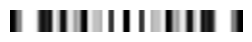


--- Iter 92 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.06620316910593513, 0.4608657788450406, 0.06620316910593467]
Mean FoM: 0.197757
Binarization degree: 0.6998


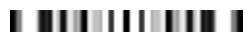


--- Iter 93 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.06600160925606934, 0.4642214177152439, 0.06600160925606896]
Mean FoM: 0.198742
Binarization degree: 0.7071


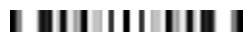


--- Iter 94 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.180
FoM values: [0.06638496372635176, 0.4633305672427162, 0.06638496372635133]
Mean FoM: 0.198700
Binarization degree: 0.7081


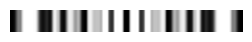


--- Iter 95 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.06599395964561677, 0.4652978155991346, 0.0659939596456168]
Mean FoM: 0.199095
Binarization degree: 0.7078


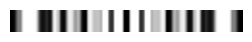


--- Iter 96 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.06593056392959626, 0.4653696235136549, 0.06593056392959612]
Mean FoM: 0.199077
Binarization degree: 0.7151


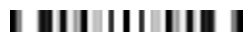


--- Iter 97 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.382
FoM values: [0.0662867842608087, 0.46565855749028817, 0.06628678426080853]
Mean FoM: 0.199411
Binarization degree: 0.7149


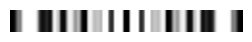


--- Iter 98 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.06561920011881046, 0.4674946539713285, 0.0656192001188103]
Mean FoM: 0.199578
Binarization degree: 0.7148


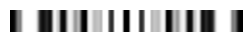


--- Iter 99 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.06626740255604688, 0.4655738045163861, 0.06626740255604634]
Mean FoM: 0.199370
Binarization degree: 0.7245


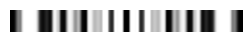


--- Iter 100 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.607
FoM values: [0.06551075657391041, 0.46870033195709015, 0.06551075657391008]
Mean FoM: 0.199907
Binarization degree: 0.7249


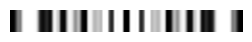


--- Iter 101 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.06629504112458656, 0.4644097511132911, 0.06629504112458616]
Mean FoM: 0.199000
Binarization degree: 0.7261


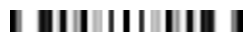


--- Iter 102 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.0650274790924192, 0.4702055149133257, 0.06502747909241861]
Mean FoM: 0.200087
Binarization degree: 0.7346


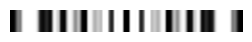


--- Iter 103 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.06654246707014079, 0.4600623010446296, 0.06654246707014005]
Mean FoM: 0.197716
Binarization degree: 0.7357


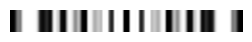


--- Iter 104 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 2.860
FoM values: [0.06351474743078996, 0.46570526214832, 0.06351474743078957]
Mean FoM: 0.197578
Binarization degree: 0.7350


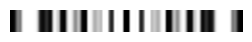


--- Iter 105 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06652444448540439, 0.462434743102835, 0.06652444448540376]
Mean FoM: 0.198495
Binarization degree: 0.7362


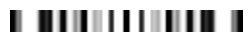


--- Iter 106 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06695453708745366, 0.46687056716040665, 0.06695453708745289]
Mean FoM: 0.200260
Binarization degree: 0.7462


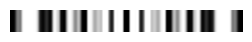


--- Iter 107 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06520154164752946, 0.47182085084028286, 0.06520154164752875]
Mean FoM: 0.200741
Binarization degree: 0.7476


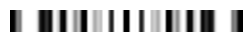


--- Iter 108 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06700252418289802, 0.4685327712407791, 0.06700252418289736]
Mean FoM: 0.200846
Binarization degree: 0.7494


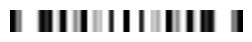


--- Iter 109 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06747827285478987, 0.4625081820646874, 0.06747827285478912]
Mean FoM: 0.199155
Binarization degree: 0.7518


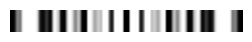


--- Iter 110 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06618739402257186, 0.46765503943905307, 0.06618739402257118]
Mean FoM: 0.200010
Binarization degree: 0.7534


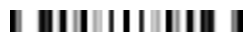


--- Iter 111 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06688107639733594, 0.46534244549336196, 0.06688107639733527]
Mean FoM: 0.199702
Binarization degree: 0.7554


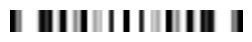


--- Iter 112 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06757237091460847, 0.4582317798633954, 0.06757237091460774]
Mean FoM: 0.197792
Binarization degree: 0.7573


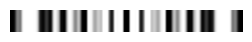


--- Iter 113 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.0669199156040261, 0.4643424301801533, 0.06691991560402545]
Mean FoM: 0.199394
Binarization degree: 0.7586


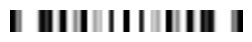


--- Iter 114 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06659059781639005, 0.46554842591330425, 0.06659059781638917]
Mean FoM: 0.199577
Binarization degree: 0.7600


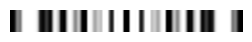


--- Iter 115 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.0676677161588475, 0.4617145904224625, 0.06766771615884691]
Mean FoM: 0.199017
Binarization degree: 0.7616


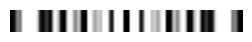


--- Iter 116 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.143
FoM values: [0.06757809302027236, 0.4647121125881936, 0.06757809302027154]
Mean FoM: 0.199956
Binarization degree: 0.7627


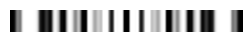


--- Iter 117 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.460
FoM values: [0.06670228717954223, 0.46902713564244997, 0.06670228717954163]
Mean FoM: 0.200811
Binarization degree: 0.7635


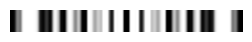


--- Iter 118 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.460
FoM values: [0.06613303981350724, 0.4737393264805105, 0.06613303981350648]
Mean FoM: 0.202002
Binarization degree: 0.7742


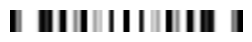


--- Iter 119 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.460
FoM values: [0.0674884564276297, 0.4637504566314506, 0.06748845642762895]
Mean FoM: 0.199576
Binarization degree: 0.7756


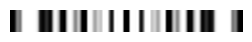


--- Iter 120 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.460
FoM values: [0.06678460385645012, 0.47467906477187927, 0.06678460385644969]
Mean FoM: 0.202749
Binarization degree: 0.7760


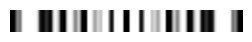


--- Iter 121 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.460
FoM values: [0.06562979688515991, 0.47605825291369147, 0.06562979688515919]
Mean FoM: 0.202439
Binarization degree: 0.7766


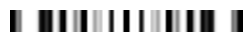


--- Iter 122 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06785073553754942, 0.47177868339925794, 0.0678507355375485]
Mean FoM: 0.202493
Binarization degree: 0.7780


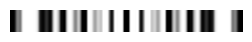


--- Iter 123 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06681974739209569, 0.4758724740157765, 0.06681974739209469]
Mean FoM: 0.203171
Binarization degree: 0.7901


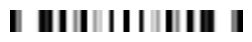


--- Iter 124 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06723769437732262, 0.47596099545461623, 0.06723769437732181]
Mean FoM: 0.203479
Binarization degree: 0.7926


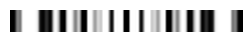


--- Iter 125 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06740551257332739, 0.47587587672919685, 0.06740551257332661]
Mean FoM: 0.203562
Binarization degree: 0.7952


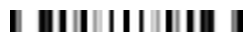


--- Iter 126 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06795637238677747, 0.47320850969216643, 0.06795637238677651]
Mean FoM: 0.203040
Binarization degree: 0.7979


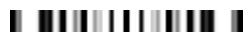


--- Iter 127 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06825025471142301, 0.4701058020419444, 0.06825025471142224]
Mean FoM: 0.202202
Binarization degree: 0.8004


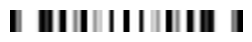


--- Iter 128 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06814255897382339, 0.4681297583242721, 0.0681425589738227]
Mean FoM: 0.201472
Binarization degree: 0.8027


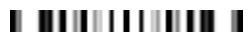


--- Iter 129 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06834028454889093, 0.4651343540006615, 0.06834028454888989]
Mean FoM: 0.200605
Binarization degree: 0.8049


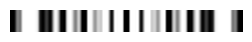


--- Iter 130 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06853870613176626, 0.46292398914968047, 0.0685387061317655]
Mean FoM: 0.200000
Binarization degree: 0.8069


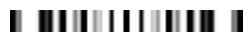


--- Iter 131 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06850770109045665, 0.4632566256346043, 0.06850770109045595]
Mean FoM: 0.200091
Binarization degree: 0.8086


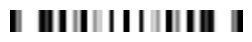


--- Iter 132 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 3.816
FoM values: [0.06874515911366423, 0.4635381642957383, 0.06874515911366312]
Mean FoM: 0.200343
Binarization degree: 0.8102


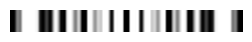


--- Iter 133 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 4.213
FoM values: [0.06904687852640497, 0.46422585803844296, 0.06904687852640409]
Mean FoM: 0.200773
Binarization degree: 0.8116


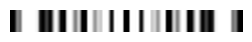


--- Iter 134 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 4.213
FoM values: [0.06787796666910585, 0.47467686860954517, 0.06787796666910537]
Mean FoM: 0.203478
Binarization degree: 0.8237


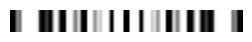


--- Iter 135 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 4.213
FoM values: [0.06958518654472153, 0.46434300615112595, 0.0695851865447207]
Mean FoM: 0.201171
Binarization degree: 0.8253


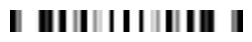


--- Iter 136 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 4.213
FoM values: [0.06877328360535827, 0.47544169586738366, 0.06877328360535723]
Mean FoM: 0.204329
Binarization degree: 0.8258


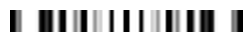


--- Iter 137 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 4.213
FoM values: [0.06791374299066513, 0.4771713919421298, 0.06791374299066433]
Mean FoM: 0.204333
Binarization degree: 0.8264


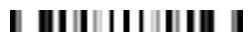


--- Iter 138 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 4.659
FoM values: [0.06995115676072475, 0.47080732174503187, 0.06995115676072357]
Mean FoM: 0.203570
Binarization degree: 0.8278


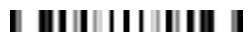


--- Iter 139 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 4.659
FoM values: [0.06833563616788146, 0.4786077772259286, 0.06833563616788062]
Mean FoM: 0.205093
Binarization degree: 0.8398


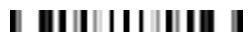


--- Iter 140 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 4.659
FoM values: [0.0692415837766808, 0.4769554030259432, 0.06924158377667974]
Mean FoM: 0.205146
Binarization degree: 0.8408


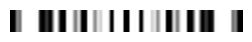


--- Iter 141 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.06964231279392011, 0.47702945180402984, 0.06964231279391939]
Mean FoM: 0.205438
Binarization degree: 0.8416


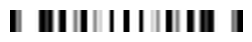


--- Iter 142 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.06749402486853393, 0.4813240845076156, 0.06749402486853295]
Mean FoM: 0.205437
Binarization degree: 0.8531


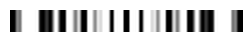


--- Iter 143 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.07044507630109796, 0.4679376990494847, 0.07044507630109707]
Mean FoM: 0.202943
Binarization degree: 0.8538


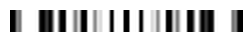


--- Iter 144 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.06995221176538043, 0.4784200829439227, 0.06995221176537945]
Mean FoM: 0.206108
Binarization degree: 0.8556


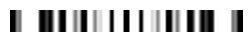


--- Iter 145 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.06934888851780263, 0.4770834179845058, 0.06934888851780142]
Mean FoM: 0.205260
Binarization degree: 0.8568


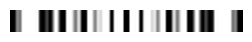


--- Iter 146 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.07143922424810321, 0.4634195716964953, 0.07143922424810217]
Mean FoM: 0.202099
Binarization degree: 0.8569


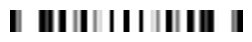


--- Iter 147 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.07100030184296685, 0.4684096467808435, 0.07100030184296591]
Mean FoM: 0.203470
Binarization degree: 0.8574


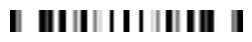


--- Iter 148 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.06993991319117139, 0.4674848133596943, 0.06993991319117042]
Mean FoM: 0.202455
Binarization degree: 0.8573


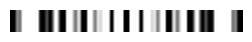


--- Iter 149 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.07178965655343314, 0.4578939381486994, 0.0717896565534321]
Mean FoM: 0.200491
Binarization degree: 0.8564


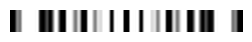


--- Iter 150 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 5.158
FoM values: [0.07185003427486836, 0.4615837512116916, 0.07185003427486729]
Mean FoM: 0.201761
Binarization degree: 0.8553


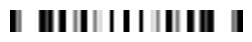

In [25]:
n = Nx * layer_num
np.random.seed(3)           
x = 0.4 + 0.2 * np.random.rand(n)  

cur_beta = 2

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.real(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # 평균 FoM 기준 변화율 계산 (💡 여기 수정!)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.005 and change2 < 0.005) and (bin_change1 < 0.002 and bin_change2 < 0.002):
            beta = beta + 12*np.tanh((beta - 0.5)*0.01)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")

    plt.figure(figsize=(3, 2))
    ax = plt.gca()
    opt_list[0].plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta

mp.verbosity(0)
Max_iter = 150

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.98:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        break

최대 FoM = 0.481324 는 iteration 425 에서 나왔습니다.


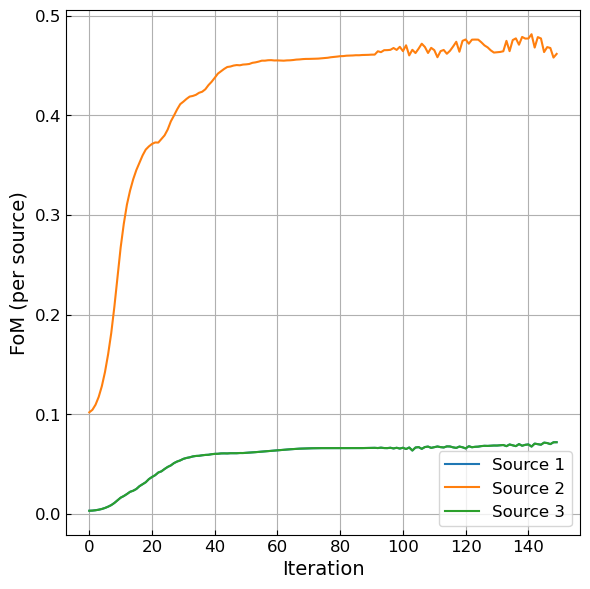

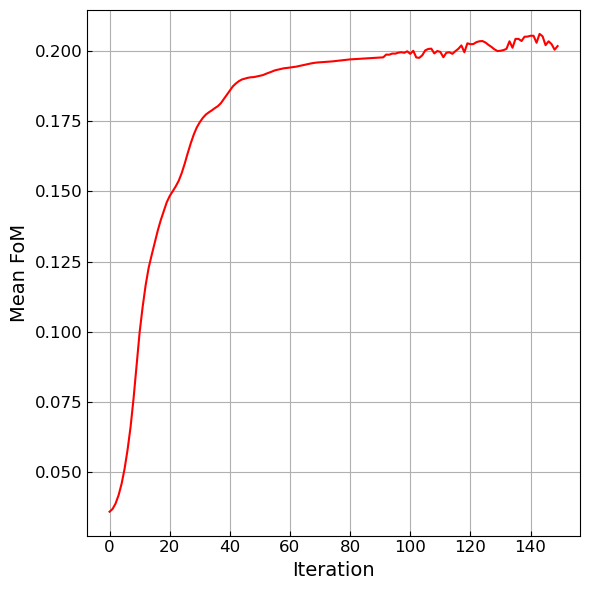

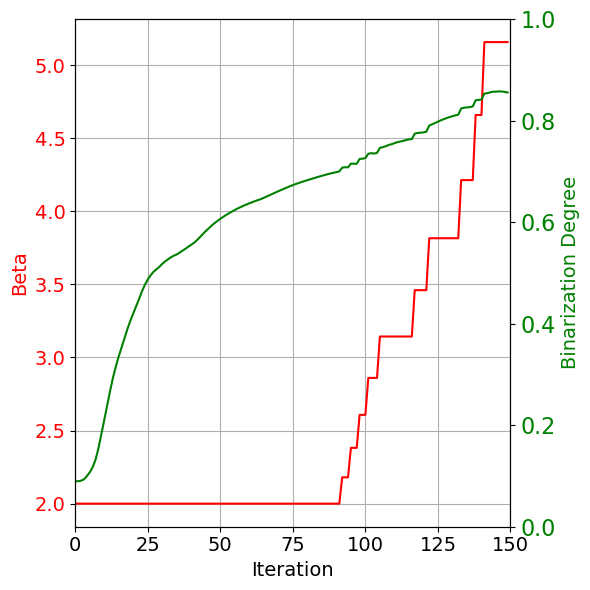

In [27]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom, 'r-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

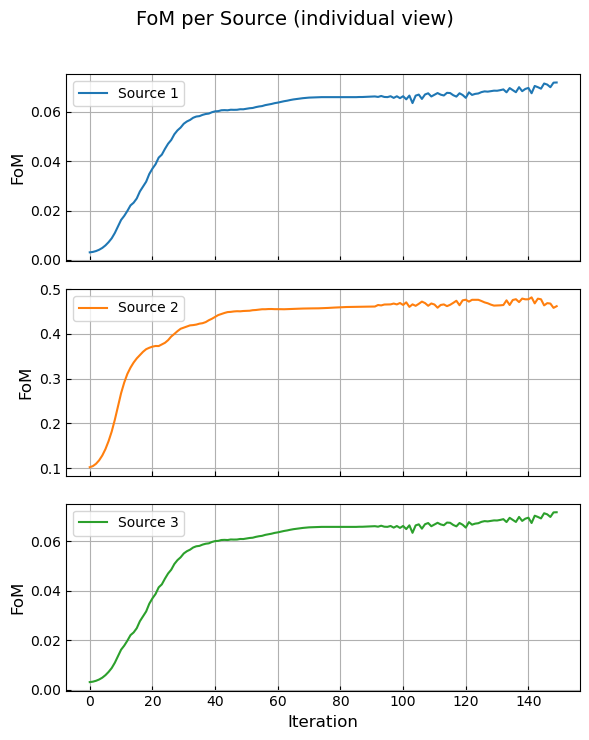

In [28]:
###################### [1-2] 각 소스별 FoM 개별 subplot ######################
num_sources = evaluation_array.shape[1]

fig, axs = plt.subplots(num_sources, 1, figsize=(6, 2.5*num_sources), sharex=True)

for i in range(num_sources):
    axs[i].plot(iterations, evaluation_array[:, i], label=f"Source {i+1}", color=f"C{i}")
    axs[i].set_ylabel("FoM", fontsize=12)
    axs[i].legend(fontsize=10)
    axs[i].grid(True)
    axs[i].tick_params(labelsize=10, direction='in')

axs[-1].set_xlabel("Iteration", fontsize=12)
fig.suptitle("FoM per Source (individual view)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [42]:
# k = design_variables.weights
# np.savetxt("Dipole_sum_new.txt", k)
design_load = np.loadtxt("Dipole_sum_new.txt")
for i in range(len(sources)):
    opt_list[i].update_design([design_load])

Plotting geometry for Source 1


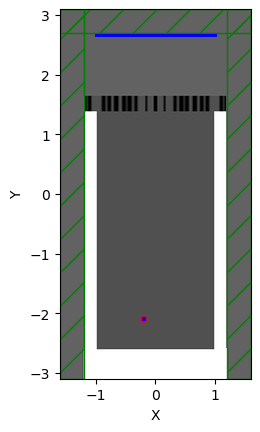

Plotting geometry for Source 2


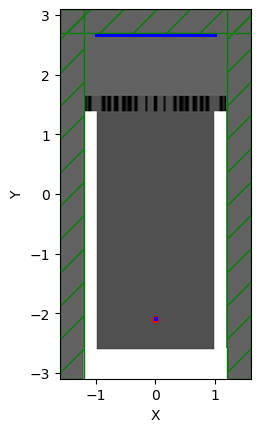

Plotting geometry for Source 3


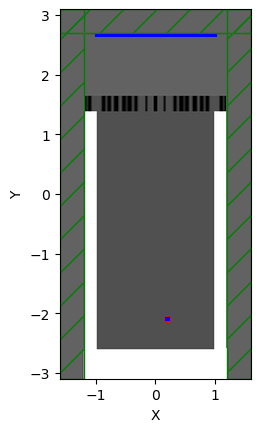

In [43]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(mn_size, 0)

input_flux_list = []
output_flux_list = []
dft_fields_list = []

for i in range(len(sources)):
    

    sim_i = opt_list[i].sim
    source_i = sources[i]

    input_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=source_i.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size),
                      weight=-1),
        mp.FluxRegion(center=source_i.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=source_i.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0),
                      weight=-1),
        mp.FluxRegion(center=source_i.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    output_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    dft_fields = sim_i.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    print(f"Plotting geometry for Source {i+1}")
    opt_list[i].plot2D()
    plt.show()


🔄 Iteration 시작 전 초기화: Source 1
▶️ Running Simulation for Source 1
📊 Plotting 2D Ez for Source 1


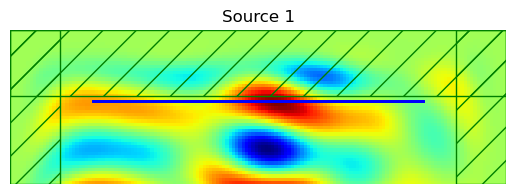

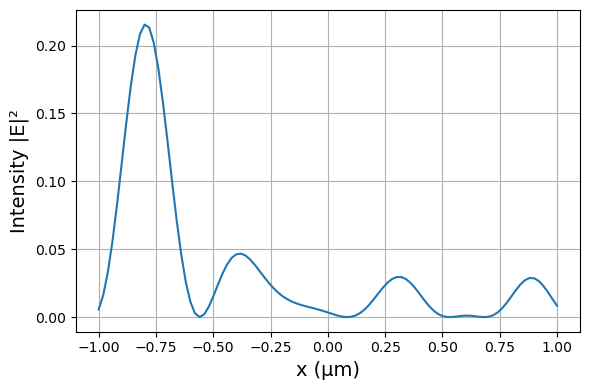


🔍 Source 1
  Input  flux : 0.114087
  Output flux : 0.095712
  EQE (%)     : 83.89 %

🔄 Iteration 시작 전 초기화: Source 2
▶️ Running Simulation for Source 2
📊 Plotting 2D Ez for Source 2


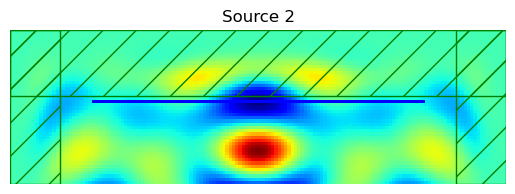

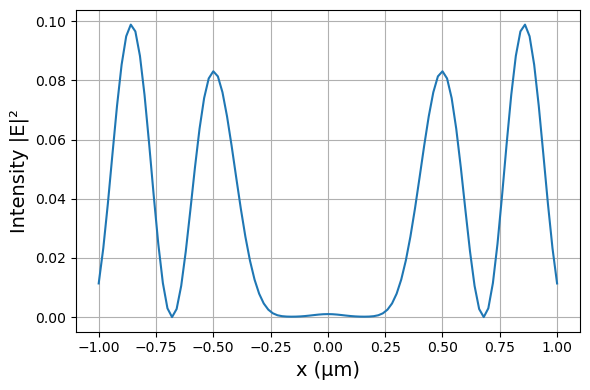


🔍 Source 2
  Input  flux : 0.177428
  Output flux : 0.069694
  EQE (%)     : 39.28 %

🔄 Iteration 시작 전 초기화: Source 3
▶️ Running Simulation for Source 3
📊 Plotting 2D Ez for Source 3


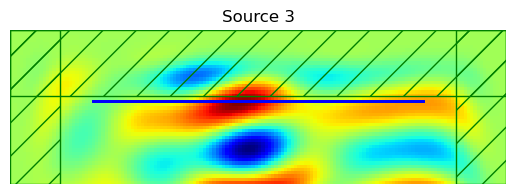

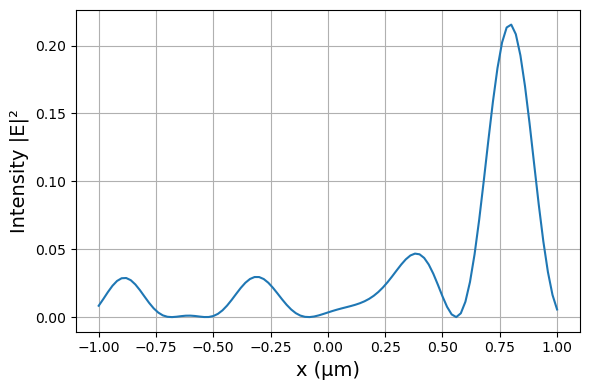


🔍 Source 3
  Input  flux : 0.114087
  Output flux : 0.095712
  EQE (%)     : 83.89 %

=== Summary EQE per source ===
Source 1: EQE = 83.89 %
Source 2: EQE = 39.28 %
Source 3: EQE = 83.89 %


In [44]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# verbosity off
mp.verbosity(0)

# parameters
offset    = 0.01
flux_size = 0.02
mn_size   = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size       = mp.Vector3(mn_size, 0)

# prepare storage
input_flux_list  = []
output_flux_list = []
dft_fields_list  = []
eqe_list         = []

# loop over sims & sources
for i, (sim, src) in enumerate(zip(sims, sources), start=1):
    print(f"\n🔄 Iteration 시작 전 초기화: Source {i}")
    sim.reset_meep()

    # add input flux monitor around the dipole
    input_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=src.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=src.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    # add output flux monitor at the planar monitor position
    output_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    # add DFT field monitor
    dft_fields = sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    # run until fields decayed
    print(f"▶️ Running Simulation for Source {i}")
    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            10/df, mp.Ez, src.center, 1e-5
        )
    )

    # spatial plot of Ez
    print(f"📊 Plotting 2D Ez for Source {i}")
    sim.plot2D(
        fields=mp.Ez,
        output_plane=mp.Volume(center=monitor_position_y,
                               size=mp.Vector3(3,1)),
        field_parameters={'post_process': lambda x: np.real(x),
                          'cmap': 'jet', 'alpha': 1,
                          'interpolation': 'none'},
        eps_parameters={'cmap':'magma','alpha':0.8}
    )
    plt.axis(False)
    plt.title(f"Source {i}", fontsize=12)
    plt.show()

    # 1D intensity profile from DFT
    E_line = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))
    x = np.linspace(-mn_size/2, mn_size/2, E_line.size)
    I = np.abs(E_line)**2

    plt.figure(figsize=(6,4))
    plt.plot(x, I, label=f"Source {i}")
    plt.xlabel('x (µm)', fontsize=14)
    plt.ylabel('Intensity |E|²', fontsize=14)
    # plt.title(f"Source {i} – Monitor size: {mn_size}µm", fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # compute EQE
    Pin  = mp.get_fluxes(input_flux)[0]
    Pout = mp.get_fluxes(output_flux)[0]
    eqe  = 100 * Pout/Pin
    eqe_list.append(eqe)

    print(f"\n🔍 Source {i}")
    print(f"  Input  flux : {Pin:.6f}")
    print(f"  Output flux : {Pout:.6f}")
    print(f"  EQE (%)     : {eqe:.2f} %")

# print summary
print("\n=== Summary EQE per source ===")
for i, val in enumerate(eqe_list, start=1):
    print(f"Source {i}: EQE = {val:.2f} %")


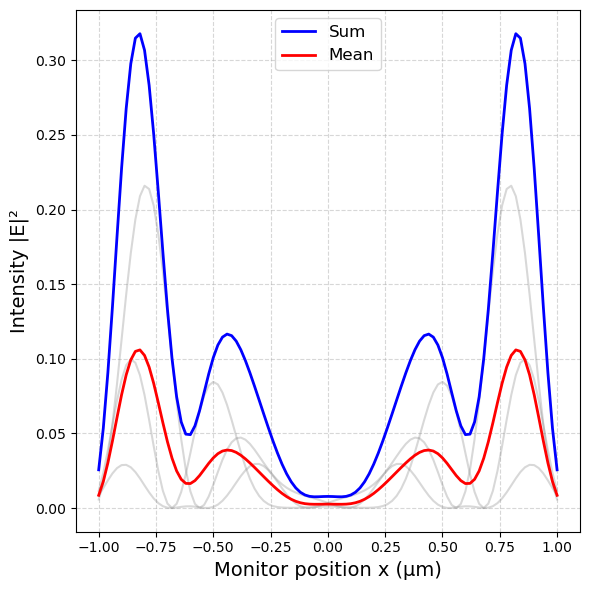

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# === 0) I_profiles 수집용 리스트 초기화 ===
I_profiles = []

# === 1) 각 sim에서 1D intensity 프로파일 계산 & 저장 ===
for sim, dft in zip(sims, dft_fields_list):
    # (이미 sim.run(...) 이 완료된 상태여야 합니다)
    E_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))  # 1D 배열 
    I = np.abs(E_line)**2                              # intensity
    I_profiles.append(I)

# === 2) x 좌표 벡터 생성 ===
N = I_profiles[0].size
x = np.linspace(-mn_size/2, mn_size/2, N)

# === 3) 합(sum) 및 평균(mean) 프로파일 계산 ===
I_stack = np.vstack(I_profiles)   # shape = (num_sources, N)
I_sum   = I_stack.sum(axis=0)     # 각 x 위치별 합
I_mean  = I_stack.mean(axis=0)    # 각 x 위치별 평균

# === 4) 한 그래프에 개별·합·평균 모두 그리기 ===
plt.figure(figsize=(6,6))

# (가) 개별 소스 프로파일: 연회색 얇은 선
for I in I_profiles:
    plt.plot(x, I, color='gray', alpha=0.3)

# (나) 합 프로파일: 검정 두꺼운 선
plt.plot(x, I_sum, 'b-', lw=2, label='Sum')

# (다) 평균 프로파일: 빨강 두꺼운 선
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')

plt.xlabel('Monitor position x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


전체 적분 범위: ±0.680 µm → P_total = 0.166310
2차 링 경계: ±0.680 µm → P2 = 0.060295, 효율 = 36.25%


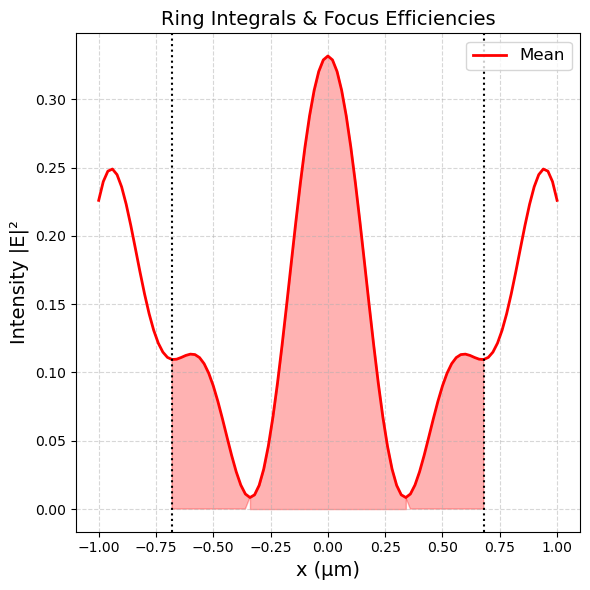

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 0) I_profiles & x, I_mean 계산 (생략 가능) ---
I_profiles = []
for sim, dft in zip(sims, dft_fields_list):
    Ez_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))
    I_profiles.append(np.abs(Ez_line)**2)

N       = I_profiles[0].size
x       = np.linspace(-mn_size/2, mn_size/2, N)
I_stack = np.vstack(I_profiles)
I_mean  = I_stack.sum(axis=0)

# --- 1) "진짜 중앙" 피크 찾기 ---
peaks, _ = find_peaks(I_mean)
if len(peaks)==0:
    center_idx = np.argmax(I_mean)
else:
    center_idx = peaks[np.argmin(np.abs(x[peaks]))]

# --- 2) 중앙 이후 첫 번째 · 두 번째 국소 최소점(dips) 검출 ---
minima_idx = []
for j in range(center_idx+1, N-1):
    if I_mean[j] < I_mean[j-1] and I_mean[j] < I_mean[j+1]:
        minima_idx.append(j)
        if len(minima_idx) >= 2:
            break

# 첫/두 번째 링 인덱스 & 좌표
ring1_idx = minima_idx[0] if len(minima_idx) > 0 else None
ring2_idx = minima_idx[1] if len(minima_idx) > 1 else None

x_ring1 = abs(x[ring1_idx]) if ring1_idx is not None else mn_size/2
x_ring2 = abs(x[ring2_idx]) if ring2_idx is not None else mn_size/2

# --- 3) 구간별 적분 및 효율 계산 ---
# 전체 적분 (|x|<=x_ring2)
mask_total = (np.abs(x) <= x_ring2)
P_total    = np.trapz(I_mean[mask_total], x[mask_total])

# 1차 링 적분 (|x|<=x_ring1)
mask1      = (np.abs(x) <= x_ring1)
P1         = np.trapz(I_mean[mask1], x[mask1])
eff1       = P1 / P_total * 100

# 2차 링 적분 (x_ring1 < |x| <= x_ring2)
mask2      = (np.abs(x) > x_ring1) & (np.abs(x) <= x_ring2)
P2         = np.trapz(I_mean[mask2], x[mask2])
eff2       = P2 / P_total * 100

# --- 4) 결과 출력 ---
print(f"전체 적분 범위: ±{x_ring2:.3f} µm → P_total = {P_total:.6f}")
# print(f"1차 링 경계: ±{x_ring1:.3f} µm → P1 = {P1:.6f}, 효율 = {eff1:.2f}%")
print(f"2차 링 경계: ±{x_ring2:.3f} µm → P2 = {P2:.6f}, 효율 = {eff2:.2f}%")

plt.figure(figsize=(6,6))
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')
plt.axvline(-x_ring2, ls=':',  color='k',)
plt.axvline(+x_ring2, ls=':',  color='k')

# interpolate=True 로 경계 채워주기
plt.fill_between(x, I_mean, where=mask1,
                 interpolate=True,
                 color='red',   alpha=0.3)
plt.fill_between(x, I_mean, where=mask2,
                 interpolate=True,
                 color='red', alpha=0.3)

plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.title('Ring Integrals & Focus Efficiencies', fontsize=14)
plt.legend(fontsize=12)
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


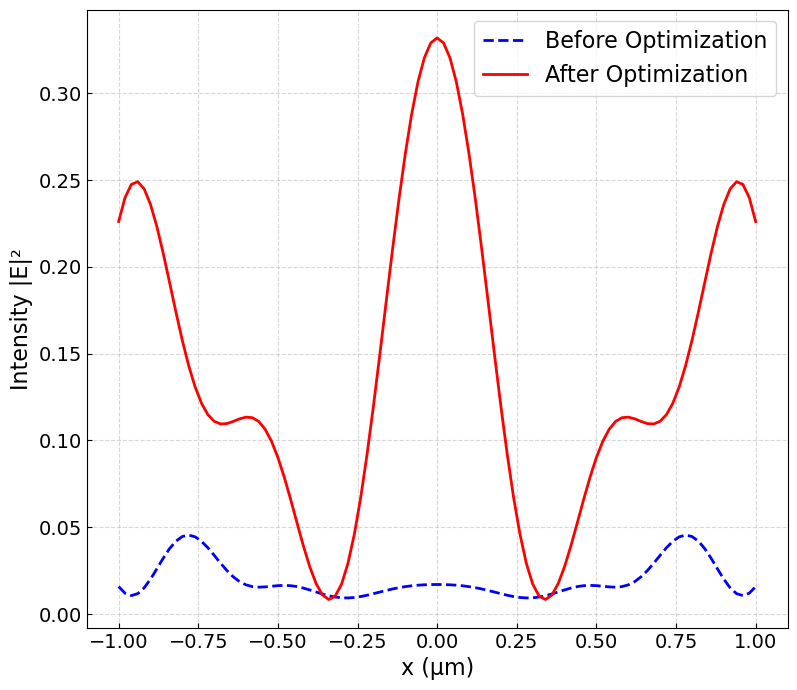

Average efficiency (Current/Saved mean): 830.20%


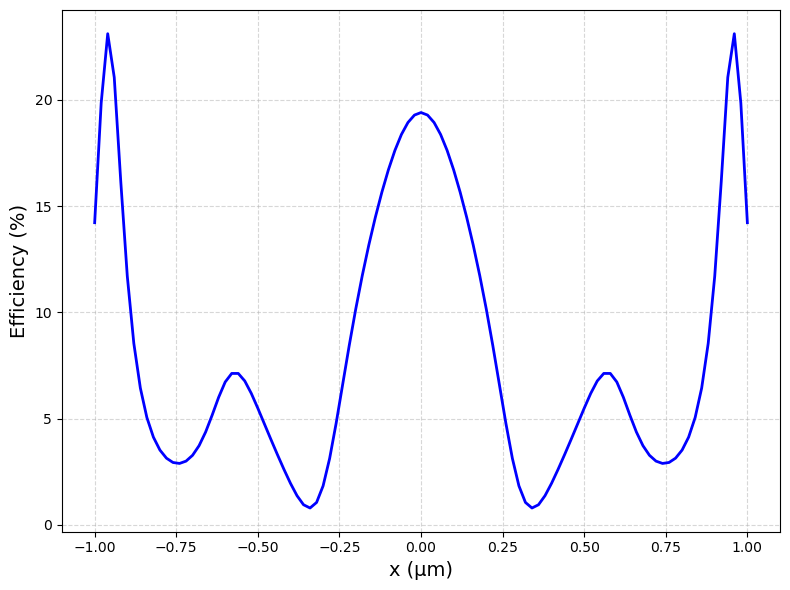

In [174]:
import numpy as np
import matplotlib.pyplot as plt

file_path = '/home/min/EIDL/Tool/Meep/LGD/LGD setup/Mode decomposition/Kyungmin/2025/07/22/Postprocess/combined_intensity.txt'

data = np.loadtxt(file_path)
x_loaded, I_sum_loaded, I_mean_loaded = data.T
plt.figure(figsize=(8,7))

plt.plot(x_loaded, I_mean_loaded, 'b--', lw=2, label='Before Optimization')

plt.plot(x, I_mean, 'r-', lw=2, label='After Optimization')

plt.xlabel('x (µm)', fontsize=16)
plt.ylabel('Intensity |E|²', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tick_params(direction = 'in')
plt.show()

eff_line = (I_mean / I_mean_loaded) 

avg_eff = np.mean(eff_line)* 100
print(f"Average efficiency (Current/Saved mean): {avg_eff:.2f}%")

plt.figure(figsize=(8,6))
plt.plot(x_loaded, eff_line, 'b-', lw=2)
plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Efficiency (%)', fontsize=14)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

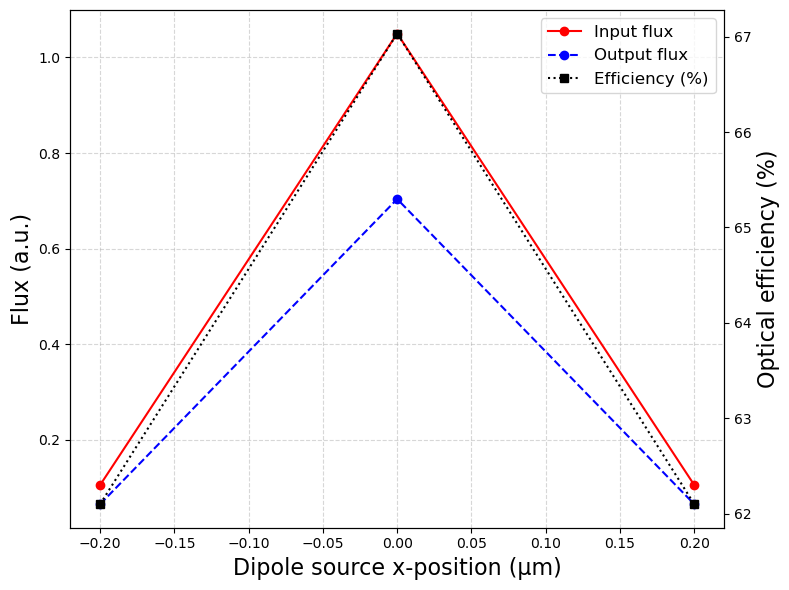

In [173]:
positions      = [src.center.x for src in sources]
input_values   = [mp.get_fluxes(f)[0] for f in input_flux_list]
output_values  = [mp.get_fluxes(f)[0] for f in output_flux_list]
percent_values = [100 * outv / inv if inv != 0 else 0
                  for inv, outv in zip(input_values, output_values)]

fig, ax1 = plt.subplots(figsize=(8,6))

# 왼쪽 축에 입력/출력 flux
ax1.plot(positions, input_values,  'ro-', label='Input flux')
ax1.plot(positions, output_values, 'bo--', label='Output flux')
ax1.set_xlabel('Dipole source x-position (µm)', fontsize=16)
ax1.set_ylabel('Flux (a.u.)',              fontsize=16, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='both', ls='--', alpha=0.5)

# 오른쪽 축에 효율
ax2 = ax1.twinx()
ax2.plot(positions, percent_values, 'ks:', label='Efficiency (%)')
ax2.set_ylabel('Optical efficiency (%)', fontsize=16, color='k')
ax2.tick_params(axis='y', labelcolor='k')

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)

plt.tight_layout()
plt.show()


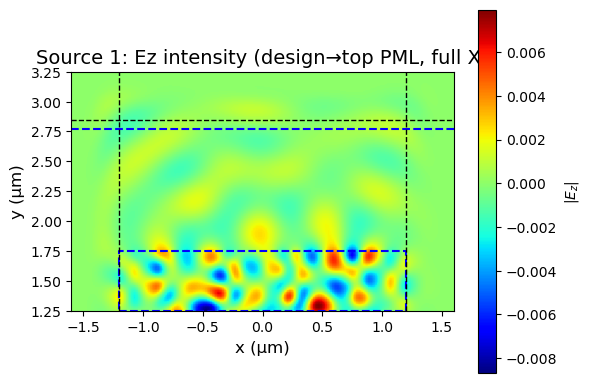

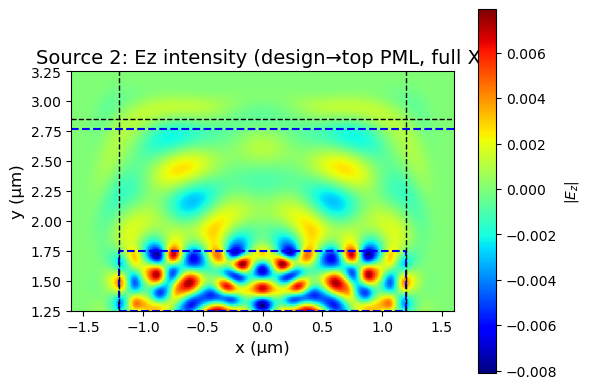

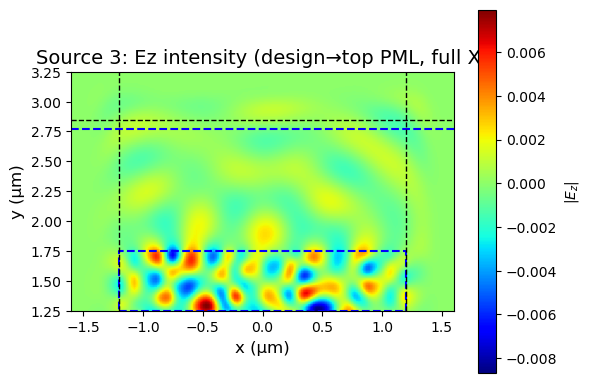

In [164]:
# 1) Y 범위: 디자인 영역 바닥→상단 PML 끝 (기존과 동일)
y_design_bot = center_y_design - design_region_height/2
y_start     = y_design_bot
y_end       = Sy/2

# 2) X 범위: 셀 전체 폭 (PML 포함)
x_start = -Sx/2
x_end   =  Sx/2

# 3) 해상도 벡터 재계산
nx   = int(resolution * Sx) + 1
x_res = np.linspace(x_start, x_end, nx)

ny   = int(resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

# 4) Volume 정의: X=Sx, Y=y_end–y_start
vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=mp.Vector3(Sx, y_end - y_start, 0)
)

# 5) 플롯 루프
# 5) 플롯 루프
for i in range(num_sources):
    Ez_slice = opt_list[i].sim.get_array(mp.Ez, vol).T
    I = np.real(Ez_slice)
    
    # I_max = np.max(np.real(Ez_slice))
    # I = np.real(Ez_slice)/I_max

    plt.figure(figsize=(6,4))
    plt.imshow(
        I,
        origin='lower',
        extent=[x_start, x_end, y_start, y_end],
        aspect='equal',
        cmap='jet'
    )
    plt.colorbar(label=r'$|E_z|$')
    plt.title(f"Source {i+1}: Ez intensity (design→top PML, full X)", fontsize=14)
    plt.xlabel('x (µm)', fontsize=12)
    plt.ylabel('y (µm)', fontsize=12)

    # — 디자인 영역 표시 —
    x0, x1 = -design_region_width/2, design_region_width/2
    y0 = y_design_bot
    y1 = y_design_bot + design_region_height
    plt.plot(
        [x0, x1, x1, x0, x0],
        [y0, y0, y1, y1, y0],
        'b--', lw=1.5, label='Design region'
    )

    # — 모니터 평면 표시 —
    plt.axhline(center_y_monitor_position, color='blue',
                ls='--', lw=1.5, label='Monitor plane')

    # — PML 경계 표시 (점선) —
    # 수평 PML 경계
    # plt.axhline(y_start + tpml,          color='yellow', ls='--', lw=1, label='Bottom PML end')
    plt.axhline(y_end   - tpml,          color='k', ls='--', lw=1, label='Top PML start')
    # 수직 PML 경계
    plt.axvline(x_start + tpml,          color='k', ls='--', lw=1, label='Left PML end')
    plt.axvline(x_end   - tpml,          color='k', ls='--', lw=1, label='Right PML start')

    # — 축범위 고정 —
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)

    # plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()



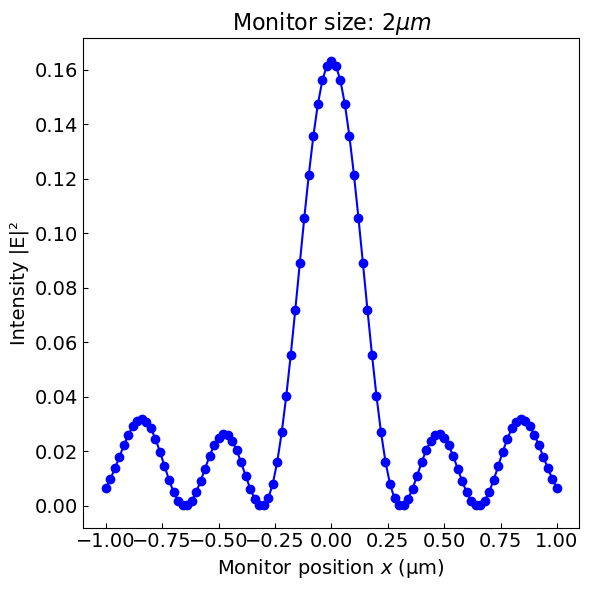

In [185]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

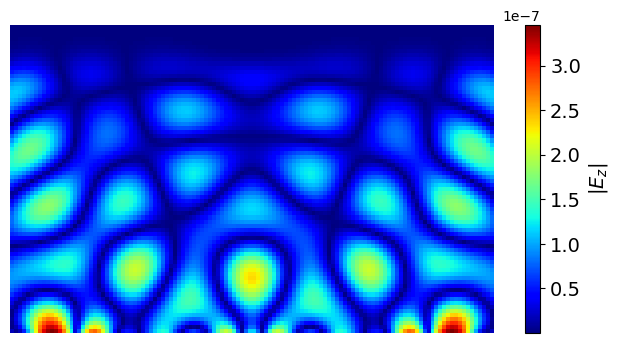

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt_list[2].sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

#### 소스 위치나 모니터 위치, 구조물 등등)

In [77]:
input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
print("Input되고 있는 flux : ", input)

NameError: name 'input_flux_list' is not defined

In [ ]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'

In [26]:
import numpy as np

# 1) 강도 계산
I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
center_idx = np.argmax(I)

# 2) 첫 번째 링 경계: 미분으로 valley 찾기
dI = np.diff(I)
valleys = np.where((dI[:-1] < 0) & (dI[1:] > 0))[0] + 1
valleys = valleys[valleys > center_idx]
if valleys.size == 0:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")
idx_valley = valleys[0]
x_limit = abs(x[idx_valley])

# 3) 적분 구간 설정
mask = (x >= -x_limit) & (x <= x_limit)
dx = x[1] - x[0]
flux_slice = np.sum(I[mask]) * dx

# 4) Flux 모니터 값
input_flux  = np.array(mp.get_fluxes(input_flux))[0]
output_flux = np.array(mp.get_fluxes(out_flux))[0]

# 5) Optical EQE 계산: 출력 flux 비율을 사용
optical_eqe = output_flux / input_flux * 100

print(f"±{x_limit:.3f} µm 구간 intensity 적분: {flux_slice:.4f}")
print(f"모니터 기반 Optical EQE: {optical_eqe:.2f}%")


±0.320 µm 구간 intensity 적분: 1.0391
모니터 기반 Optical EQE: 75.64%


In [287]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'